In [580]:
# Import pandas, numpy
import pandas as pd
import numpy as np

# Import warnings
import warnings
warnings.filterwarnings('ignore')

# Import matplotlib for plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, accuracy_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# feature importance
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

pd.set_option('display.max_columns', 500)

#### **1.1 Creating functions for data exploring** 

In [581]:
# Basic exploration information about the dataframe
def basic_information(df):
    df_cols=list(df.columns)
    print("Basic information")
    print("Shape of DF:", df.shape)

    for col in df_cols:
        print("Name: {}".format(df[col].name))
        print("Type: {}".format(df[col].dtype))
        print("Unique values: {}".format(len(df[col].unique())))
        print("NaN values: {}".format(df[col].isna().sum()))
        print("0 values: {}".format(df[col].isin([0]).sum()))
        plt.hist(df[col],bins=20)
        plt.show()
        print("Value counts:\n{}".format(df[col].value_counts()))
        print (" ")
        print("==========================================")
        print(" ")

In [582]:
# Checking null values and 0 values
def gettingzeros(df):
  df_cols=list(df.columns)
  print("Checking Null Values")
  print(" ")
  storage_balance = []
  
  for col in df_cols:
    print("Name: {}".format(df[col].name))
    print("NaN values: {}".format(df[col].isna().sum()))
    print("0 values: {}".format(df[col].isin([0]).sum()))
    print(" ")

In [583]:
# master function to explore data
def explore_data(df):
  basic_information(df)
  gettingzeros(df)

In [584]:
 # clean nulls in balances
 def cleaning_nulls(df):
  df = df[df['balance_q1'] > 0]
  df = df[df['balance_q2'] > 0]
  df = df[df['balance_q3'] > 0]
  return df

In [585]:
# drop dupplicates or drop a list you want
def dropping(df,drop_list=None):
  df.drop_duplicates()
  if drop_list != None:
    df.drop(drop_list=None, axis = 1, inplace = True)
  return df

In [586]:
# cluster values that are not frequent in one category
def clean_household_size(x):
  if x > 5:
    return 6
  else:
    return x

def clean_cc_held(x):
  if x > 2:
    return 2
  else:
    return x

def clustering_columns(df):
  df.household_size = list(map(clean_household_size, df.household_size))
  df.credit_cards_held = list(map(clean_cc_held, df.credit_cards_held))
  df.nr_of_bank_accounts_open = list(map(lambda x: 1 if x == 1 else 2,df.nr_of_bank_accounts_open))
  df.nr_of_homes_owned = list(map(lambda x: 1 if x == 1 else 2,df.nr_of_homes_owned))
  return df

In [587]:
# master cleaning function that calls the functions above
def cleaning_columns(df, drop_list=None):
  df = cleaning_nulls(df)
  df = dropping(df,drop_list=None)
  df = clustering_columns(df)
  return df

#### **2.1 Creating functions for data categories**

In [588]:
# data separation in types: categorical,  numerical discrete and continuous
def data_sep(df,types, target=None):
    num_discrete = []
    num_continuous = []
    num = df.select_dtypes(include = np.number)
    for i in num.columns:
        if 'balance' in i:
            num_continuous.append(i)
        else:
            num_discrete.append(i)
    if types == 'numerical':
        return num
    elif types == 'discrete':
        return df[num_discrete]
    elif types == 'continuous':
        return df[num_continuous]
    else:
        cat = df.select_dtypes(include = np.object)
        #cat = cat.drop(target, axis = 1)
        return cat

In [589]:
# plots from different data categories
def plots(df, types):
    import seaborn as sns
    if types == 'correlation matrix':
      corr_matrix=df.corr(method='pearson')
      fig, ax = plt.subplots(figsize=(10, 8))
      mask = np.zeros_like(corr_matrix)
      mask[np.triu_indices_from(mask)] = True
      ax = sns.heatmap(corr_matrix, mask=mask, annot=True)
      return plt.show()
    elif types == 'describe':
      print(df.describe().T)
      print(" ")
      return df.describe()
    for i in df.columns:
      print('Column: ',i)
      if types == 'continuous':
        sns.distplot(df[i])
      elif types == 'categorical' or types == 'discrete':
        sns.countplot(x=i,data=df)
      elif types == 'boxplot':
        sns.boxplot(x=i, data=df)
      plt.show()
      print('====================')

In [590]:
# master plot  with all the plots we want to plot
def plot_master():
  print("** PLOTTING NUM DESCRIBE **")
  plots(df,'describe')

  print("** PLOTING CATEGORICAL VARIABLES **")
  plots(cat,'categorical')
  print(" ")

  print("** PLOTING CONTINUOUS VARIABLES **")
  plots(num_cont, 'continuous')
  print(" ")

  print("** PLOTTING DISCRETE VARIABLES **")
  plots(num_disc,'discrete')
  print(" ")

  print("** PLOTTING CORRELATION MATRIX **")
  plots(num,'correlation matrix')

In [591]:
# function to see the skew in numerical continuous
def skew_df(df):
    from scipy.stats import skew
    
    cols=list(df.columns)
    
    for col in cols:
        sk=df[col].skew()
        print("the skew of {} is: {}".format(col,sk))

In [592]:
# getting VIF scores
def vif_scores(df):
    VIF_Scores = pd.DataFrame()
    VIF_Scores['independent_features'] = num.columns
    VIF_Scores['vif_score'] = [variance_inflation_factor(num.values,i) for i in range(num.shape[1])]
    return VIF_Scores

In [593]:
# checking categorical dependency with chi-test
def chi_test(df,x,y):
    from scipy.stats import chi2_contingency
    from scipy.stats import chi2
    # contingency table
    table = pd.crosstab(df[x], df[y])
    print(table)
    stat, p, dof, expected = chi2_contingency(table)
    print('dof=%d' % dof)
    print(expected)
    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('!!!!! DEPENDENT (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    print('==========================================================')

In [594]:
# apply chi-test for all categoricals
def applying_chi_test(cat):
  for i in cat.columns:
    for v in cat.columns:
        if i != v:
            print('==========================================================')
            print('RELATIONSHIP {} and {}'.format(i.upper(),v.upper()))
            chi_test(cat,i,v)

#### **3.1 Creating functions for data encoding**

In [595]:
# convert categrical ordinals 
def ordinals_conversor(df):
  df2 = df.copy()
  for col in df2:
    if len(df2[col].unique()) > 2:
      df2[col]= list(map(lambda x: 2 if x == 'High' else (0 if x == 'Low' else 1),df2[col]))
    else:
      df2[col]= list(map(lambda x: 1 if x =='Yes' else 0,df2[col]))
    return df2

In [596]:
# master conversor. Encodes all categoricals
def converting_categoricals(cat):
  df = cat.copy()
  df = ordinals_conversor(df)
  df2 = pd.get_dummies(df)
  return df2

#### **4.1 Creating functions for prediction**

In [597]:
# spliting data in features and targte
def split_xy(cat,num):
  #Concatenating numericals and categoricals 
  df = pd.concat([cat,num],axis=1)
  y = pd.DataFrame(df['offer_accepted'])
  X = df.drop(['offer_accepted'],axis=1)
  #returning X (features) and y (target) dataframes
  return X,y


In [598]:
# splitting data into train and test
def splitting_data(X,y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  return X_train, X_test, y_train, y_test

In [599]:
# scalers functions
def scalers(X_train, X_test, scaler):
    if scaler == 'normalizer':
        transformer = Normalizer().fit(X_train)
        X_train_t = transformer.transform(X_train)
        X_test_t = transformer.transform(X_test) 
    elif scaler == 'standard':
        transformer = StandardScaler().fit(X_train)
        X_train_t = transformer.transform(X_train)
        X_test_t = transformer.transform(X_test)
    elif scaler == 'minmax':
        transformer = MinMaxScaler().fit(X_train)
        X_train_t = transformer.transform(X_train)
        X_test_t = transformer.transform(X_test)
    elif scaler == 'power':
        transformer = PowerTransformer().fit(X_train)
        X_train_t = transformer.transform(X_train)
        X_test_t = transformer.transform(X_test)

    X_train_t = pd.DataFrame(X_train_t, columns = X_train.columns)
    X_test_t = pd.DataFrame(X_test_t, columns = X_test.columns)

    return X_train_t, X_test_t

In [600]:
# sampling functions
def samplings_type(X_train, y_train, samp):
    if samp =='downsampling':
        s = RandomUnderSampler()
    elif samp == 'upsampling':
        s = RandomOverSampler()
    elif  samp == 'tomeklinks':
        s = TomekLinks('majority')

    X_s, y_s = s.fit_sample(X_train, y_train)
    X_train_s = pd.DataFrame(X_s, columns = X_train.columns)
    y_train_s = pd.DataFrame(y_s, columns = ['offer_accepted'])

    return X_train_s, y_train_s

In [601]:
# predict function accuracies and kappas
def fit_predict(X_train, X_test, y_train, y_test, model='logistic', k=4):
    import sys
    from sklearn.metrics import accuracy_score, precision_score
    if ( model == 'logistic' ):
        classification = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr').fit(X_train, y_train)
    elif ( model == 'decision_tree' ):
        classification = DecisionTreeClassifier().fit(X_train, y_train)
    elif ( model == 'k-nn'):
          classification = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    else:
        print('Incorrect input model')
        sys.exit()

    y_train_pred = classification.predict(X_train)
    y_test_pred  = classification.predict(X_test)

    accuracy_train = round(accuracy_score(y_train, y_train_pred),2)
    accuracy_test  = round(accuracy_score(y_test, y_test_pred),2)

    kappa_train = round(cohen_kappa_score(y_train, y_train_pred),2)
    kappa_test  = round(cohen_kappa_score(y_test, y_test_pred),2)

    return accuracy_train, accuracy_test, kappa_train, kappa_test

In [637]:
# function that returns y_test_predict
def y_predict(X_train, X_test, y_train, y_test, model='logistic', k=4):
    import sys

    if ( model == 'logistic' ):
        classification = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr').fit(X_train, y_train)
        #classification.to_pickle('')
    elif ( model == 'decision_tree' ):
        classification = DecisionTreeClassifier().fit(X_train, y_train)
    elif ( model == 'k-nn' ):
          classification = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    else:
        print('Incorrect input model')
        sys.exit()

    y_train_pred = classification.predict(X_train)
    y_test_pred  = classification.predict(X_test)
    return y_test_pred

In [636]:
# applying scaling, sampling and predicting
def get_scores(X,y, model,k=4):
    from sklearn.metrics import precision_score, recall_score
    X_train, X_test, y_train, y_test = splitting_data(X,y)

    my_dict =  {'scaler': [], 'sampling': [], 'precision':[],'recall':[],'accuracy': [], 'kappa': [], 'set': []}

    for scaler in ['normalizer','standard','minmax','power']:
        for sampling in ['downsampling','upsampling','tomeklinks']:

            X_train_t, X_test_t = scalers(X_train, X_test, scaler)
            X_train_s, y_train_s = samplings_type(X_train_t, y_train, sampling)

            accuracy_train, accuracy_test, kappa_train, kappa_test = fit_predict(X_train_s, X_test_t, y_train_s, y_test, model)
            y_pred = y_predict(X_train_s, X_test_t, y_train_s, y_test, model,k=4)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)

            my_dict['scaler'].append(scaler)
            my_dict['sampling'].append(sampling)
            my_dict['precision'].append(precision)
            my_dict['recall'].append(recall)
            my_dict['accuracy'].append(accuracy_train)
            my_dict['kappa'].append(kappa_train)
            my_dict['set'].append('train')

            my_dict['scaler'].append(scaler)
            my_dict['sampling'].append(sampling)
            my_dict['precision'].append(precision)
            my_dict['recall'].append(recall)
            my_dict['accuracy'].append(accuracy_test)
            my_dict['kappa'].append(kappa_test)
            my_dict['set'].append('test')

    results = pd.DataFrame(my_dict)
    return results

In [638]:
# confusion matrix information
def confusion_matrix_info(X,y,scaler,samp,model):

  X_train, X_test, y_train, y_test = splitting_data(X,y)

  X_train_t, X_test_t = scalers(X_train, X_test,scaler)

  X_train_s, y_train_s = samplings_type(X_train_t, y_train, samp)

  if ( model == 'logistic' ):
    classification = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr').fit(X_train_s, y_train_s)
  elif ( model == 'decision_tree' ):
    classification = DecisionTreeClassifier().fit(X_train_s, y_train_s)
  elif ( model == 'k-nn' ):
    classification = KNeighborsClassifier(n_neighbors=4).fit(X_train_s, y_train_s)

  y_test_pred = classification.predict(X_test_t)
  print('\033[1m'+"The accuracy score in the TEST set is {}".format(round(accuracy_score(y_test,y_test_pred),2)))
  print(" ")
  print('\033[1m'+"The y test value counts are"+'\033[0m'+ "\n {}".format(round(y_test.value_counts(),2)))
  print(" ")
  print('\033[1m'+"Confusion matrix y_test,predictions"+'\033[0m')
  print(confusion_matrix(y_test, y_test_pred))
  print(" ")
  print('\033[1m'+"Confusion matrix X_test_t,y_test"+'\033[0m')
  return plot_confusion_matrix(classification, X_test_t, y_test)

In [605]:
# feature importance function
def feature_importance(X,y,model):
  # define and fit the model
  # get importance
  if model == 'logistic':
    model = LogisticRegression().fit(X,y)
    importance = model.coef_[0]
  elif model ==  'decision_tree':
    model = DecisionTreeRegressor().fit(X,y)
    importance = model.feature_importances_

  # summarize feature importance
  for i,v in enumerate(importance):
      print('Feature: %0d, Score: %.5f' % (i,v))
  # plot feature importance
  pyplot.bar([x for x in range(len(importance))], importance)
  pyplot.show()

#### **5.1 Master functions to try different data**

In [606]:
# prepare new dataframe with instructions given in dict_of_steps to process it again
def preprocess(df, dict_of_steps, nombre = None):

  df2 = df.copy()
  for step in list(dict_of_steps.keys()):
    if ( step == 'drop_outliers' and dict_of_steps['drop_outliers'] == 'Yes'):
      iqr = np.percentile(df2['average_balance'],75) - np.percentile(df2['average_balance'],25)
      upper_limit = np.percentile(df2['average_balance'],75) + 1.5*iqr
      df2 = df2[(df2['average_balance']<upper_limit)]
    if ( step == 'drop_cols' and len(dict_of_steps['drop_cols']) != 0):
      df2.drop(columns=dict_of_steps['drop_cols'], axis=1, inplace= True)
    if ( step == 'outliers' and dict_of_steps['outliers'] == 'Yes'):
      iqr = np.percentile(df2['average_balance'],75) - np.percentile(df2['average_balance'],25)
      upper_limit = np.percentile(df2['average_balance'],75) + 1.5*iqr
      df2 = df2[(df2['average_balance']>upper_limit)]

  if (nombre != None):
    file_name = '/content/drive/MyDrive' + nombre
    df2.to_csv(file_name, encoding='utf-8', index=False)

  return df2

In [607]:
# master function that split features and target when we process again the dataframe
def master_xy(df):
  num = data_sep(df,'numerical')
  cat = data_sep(df,'cat','offer_accepted')
  cat = converting_categoricals(cat)
  X,y = split_xy(cat,num)
    
  return X,y

# master function that shows the confusion matrix and metrics(accuracy, recall and kappa) 
# when we process again the dataframe
def master_scores_confusion_matrix(df,model,scaler,samp):
  X,y = master_xy(df)

  print(" ")
  print('\033[1m'+"Confusion Matrix info"+'\033[0m')
  confusion_matrix_info(X,y,scaler,samp,model)
  plt.show()

  print('\033[1m'+"SCORES"+'\033[0m')
  scores = get_scores(X,y,model)
  return scores

# master functiono to check dependency: chi tesst in categoricals,
# skew in numericals and VIF in numericals.
# Feature importance in features
def master_chi_skew_vif(df):
  num = data_sep(df,'numerical')
  cat = data_sep(df,'cat','offer_accepted')
  cat = cat.drop('offer_accepted',axis=1)
  print('\033[1m'+"CHI TEST"+'\033[0m')
  print(" ")
  applying_chi_test(cat)

  print('\033[1m'+"SKEW TEST"+'\033[0m')
  print(" ")
  skew_df(num)

  print('\033[1m'+"VIF TEST"+'\033[0m')
  print(" ")
  vif_scores(num)

  print('\033[1m'+"FEATURE IMPORTANCE"+'\033[0m')
  print(" ")
  X,y = master_xy(df)
  feature_importance(X,y,model)
  return X

# **0. Loading original DF**

In [608]:
# original DF
df = pd.read_csv('/content/drive/MyDrive/creditcardmarketing.csv', names= ['offer_accepted','reward','mailer_type','income_level','bank_accounts_open','overdraft_protection','credit_rating','credit_cards_held','homes_owned','household_size','own_your_home','avg_balance','q1_balance','q2_balance','q3_balance','q4_balance'])
df.head()


,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,avg_balance,q1_balance,q2_balance,q3_balance,q4_balance
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [609]:
df.columns = ['offer_accepted','reward','mailer_type','income_level','nr_of_bank_accounts_open','overdraft_protection','credit_rating','credit_cards_held','nr_of_homes_owned','household_size','own_your_home','average_balance','balance_q1','balance_q2','balance_q3','balance_q4']

In [610]:
df.drop('balance_q4',axis=1,inplace=True)

In [611]:
df.dropna(inplace= True)

In [395]:
#dropping customer_id, not needed
#df = df.drop('customer_id',axis=1)

# **5. Trying different datasets after doing the model in raw data**

In [629]:
#### MODIFY my_dict TO TRY creating DIFFERENT DFs 
my_dict = {'drop_outliers': 'No', 'drop_cols': ['household_size','credit_cards_held','average_balance','balance_q1','balance_q2','balance_q3','nr_of_homes_owned'], 'outliers': 'No'}
# include another argument,if you want, to save your new df. E.g.: 'df_with_outliers.csv'
df = preprocess(df,my_dict)

In [632]:
# choose a model, scaler and sampling for testing
# confusion matrix and/or metrics.
# Options you can choose from:
# model:'logistic','decision_tree','k-nn'
# scaler: 'standard','normalizer','minmax','power' (power transform)
# samp: 'upsampling','downsampling','tomeklinks'
model = 'logistic'
scaler = 'standard'
samp  = 'upsampling'

 
Confusion Matrix info
The accuracy score in the TEST set is 0.68
 
The y test value counts are
 offer_accepted
0                 5072
1                  319
dtype: int64
 
Confusion matrix y_test,predictions
[[3436 1636]
 [  92  227]]
 
Confusion matrix X_test_t,y_test


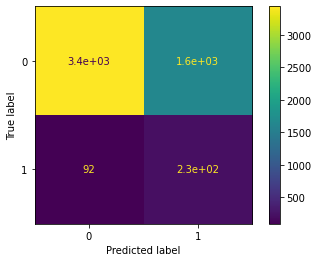

SCORES


,scaler,sampling,precision,recall,accuracy,kappa,set
0,normalizer,downsampling,-,-,0.68,0.36,train
1,normalizer,downsampling,0.115266,0.705329,0.66,0.11,test
2,normalizer,upsampling,-,-,0.69,0.38,train
3,normalizer,upsampling,0.118922,0.705329,0.67,0.11,test
4,normalizer,tomeklinks,-,-,0.94,0.00,train
5,normalizer,tomeklinks,0,0,0.94,0.00,test
6,standard,downsampling,-,-,0.70,0.40,train
7,standard,downsampling,0.123295,0.708464,0.68,0.12,test
8,standard,upsampling,-,-,0.69,0.38,train
9,standard,upsampling,0.118045,0.711599,0.67,0.11,test


In [635]:
# Check metrics and confusion matrix for new DF
master_scores_confusion_matrix(df,model,scaler,samp)

CHI TEST
 
RELATIONSHIP REWARD and MAILER_TYPE
mailer_type  Letter  Postcard
reward                       
Air Miles      2945      3101
Cash Back      2965      3028
Points         2930      3000
dof=2
[[2974.38032167 3071.61967833]
 [2948.30652791 3044.69347209]
 [2917.31315043 3012.68684957]]
probability=0.950, critical=5.991, stat=0.866
Independent (fail to reject H0)
significance=0.050, p=0.649
Independent (fail to reject H0)
RELATIONSHIP REWARD and INCOME_LEVEL
income_level  High   Low  Medium
reward                          
Air Miles     1491  1532    3023
Cash Back     1534  1466    2993
Points        1492  1456    2982
dof=4
[[1519.82759196 1498.63008515 3027.54232289]
 [1506.50459124 1485.49290445 3001.00250431]
 [1490.6678168  1469.87701041 2969.4551728 ]]
probability=0.950, critical=9.488, stat=2.261
Independent (fail to reject H0)
significance=0.050, p=0.688
Independent (fail to reject H0)
RELATIONSHIP REWARD and OVERDRAFT_PROTECTION
overdraft_protection    No  Yes
reward

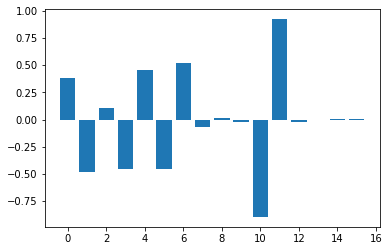

,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes,nr_of_bank_accounts_open
1,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1
2,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1,1
3,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1,2
4,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,2
5,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,1
17997,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,1
17998,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1
17999,0,1,0,1,0,0,0,1,1,0,0,0,1,0,1,1


In [634]:
# Check dependency in categoricals and numericals new DF
master_chi_skew_vif(df)

# **1. Data Exploration**

#### **1.2 Applying cleaner and basic information**

Basic information
Shape of DF: (17976, 15)
Name: offer_accepted
Type: object
Unique values: 2
NaN values: 0
0 values: 0


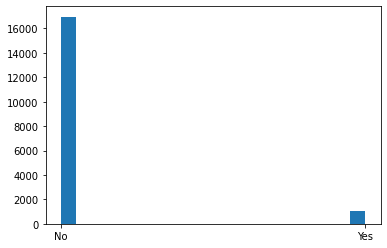

Value counts:
No     16955
Yes     1021
Name: offer_accepted, dtype: int64
 
 
Name: reward
Type: object
Unique values: 3
NaN values: 0
0 values: 0


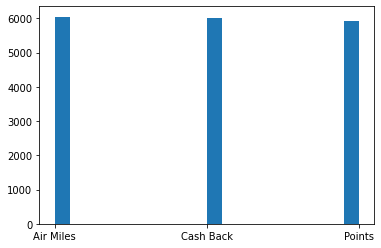

Value counts:
Air Miles    6047
Cash Back    5995
Points       5934
Name: reward, dtype: int64
 
 
Name: mailer_type
Type: object
Unique values: 2
NaN values: 0
0 values: 0


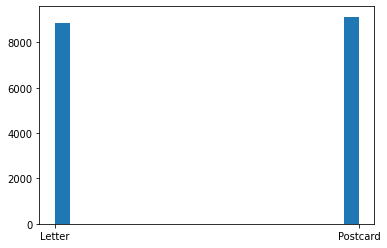

Value counts:
Postcard    9134
Letter      8842
Name: mailer_type, dtype: int64
 
 
Name: income_level
Type: object
Unique values: 3
NaN values: 0
0 values: 0


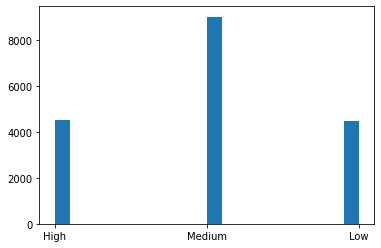

Value counts:
Medium    9002
High      4519
Low       4455
Name: income_level, dtype: int64
 
 
Name: nr_of_bank_accounts_open
Type: int64
Unique values: 3
NaN values: 0
0 values: 0


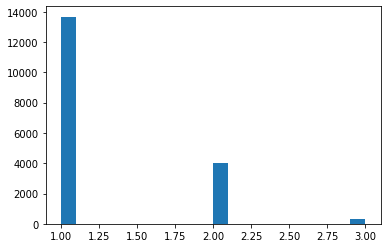

Value counts:
1    13674
2     4007
3      295
Name: nr_of_bank_accounts_open, dtype: int64
 
 
Name: overdraft_protection
Type: object
Unique values: 2
NaN values: 0
0 values: 0


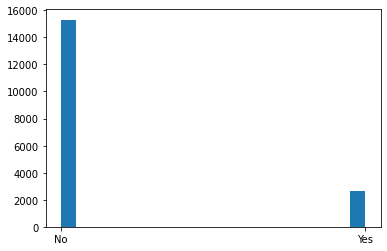

Value counts:
No     15300
Yes     2676
Name: overdraft_protection, dtype: int64
 
 
Name: credit_rating
Type: object
Unique values: 3
NaN values: 0
0 values: 0


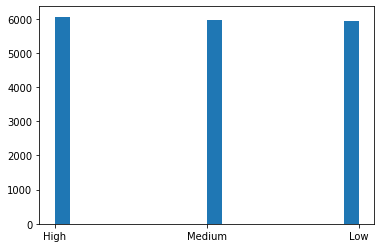

Value counts:
High      6064
Medium    5964
Low       5948
Name: credit_rating, dtype: int64
 
 
Name: credit_cards_held
Type: int64
Unique values: 4
NaN values: 0
0 values: 0


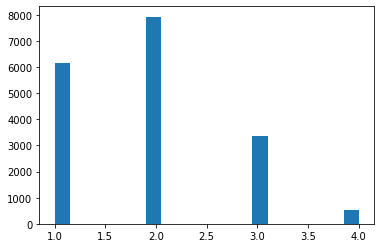

Value counts:
2    7933
1    6147
3    3381
4     515
Name: credit_cards_held, dtype: int64
 
 
Name: nr_of_homes_owned
Type: int64
Unique values: 3
NaN values: 0
0 values: 0


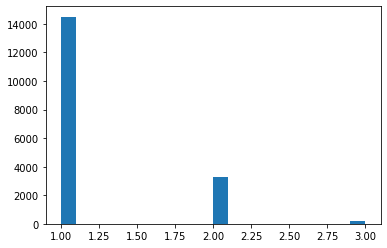

Value counts:
1    14502
2     3289
3      185
Name: nr_of_homes_owned, dtype: int64
 
 
Name: household_size
Type: int64
Unique values: 8
NaN values: 0
0 values: 0


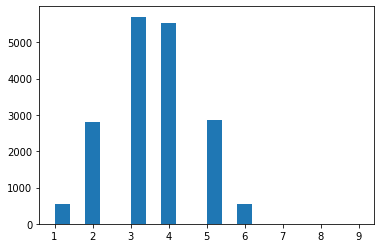

Value counts:
3    5705
4    5532
5    2851
2    2809
1     539
6     538
9       1
8       1
Name: household_size, dtype: int64
 
 
Name: own_your_home
Type: object
Unique values: 2
NaN values: 0
0 values: 0


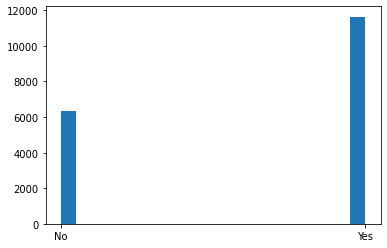

Value counts:
Yes    11636
No      6340
Name: own_your_home, dtype: int64
 
 
Name: average_balance
Type: float64
Unique values: 4728
NaN values: 0
0 values: 0


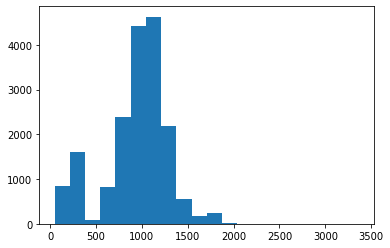

Value counts:
1127.00    17
1053.50    16
1078.50    16
1036.00    16
1033.00    16
           ..
596.75      1
379.50      1
1514.00     1
375.75      1
177.25      1
Name: average_balance, Length: 4728, dtype: int64
 
 
Name: balance_q1
Type: float64
Unique values: 2158
NaN values: 0
0 values: 5


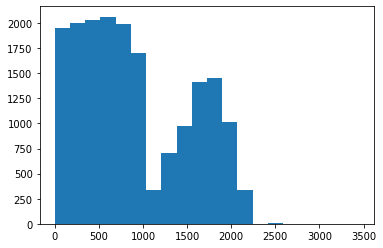

Value counts:
675.0     23
81.0      23
823.0     22
676.0     22
557.0     21
          ..
1126.0     1
2002.0     1
2123.0     1
1199.0     1
1073.0     1
Name: balance_q1, Length: 2158, dtype: int64
 
 
Name: balance_q2
Type: float64
Unique values: 1945
NaN values: 0
0 values: 1


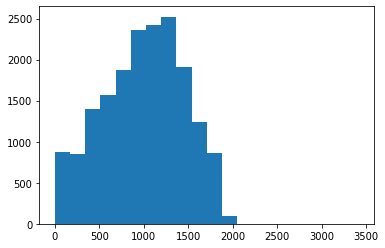

Value counts:
1060.0    30
1197.0    26
1271.0    25
1132.0    24
826.0     24
          ..
1954.0     1
1850.0     1
1907.0     1
77.0       1
1862.0     1
Name: balance_q2, Length: 1945, dtype: int64
 
 
Name: balance_q3
Type: float64
Unique values: 2281
NaN values: 0
0 values: 1


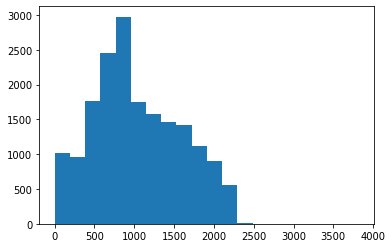

Value counts:
809.0     30
833.0     27
972.0     26
842.0     26
997.0     26
          ..
1196.0     1
2152.0     1
2576.0     1
2229.0     1
342.0      1
Name: balance_q3, Length: 2281, dtype: int64
 
 
Checking Null Values
 
Name: offer_accepted
NaN values: 0
0 values: 0
 
Name: reward
NaN values: 0
0 values: 0
 
Name: mailer_type
NaN values: 0
0 values: 0
 
Name: income_level
NaN values: 0
0 values: 0
 
Name: nr_of_bank_accounts_open
NaN values: 0
0 values: 0
 
Name: overdraft_protection
NaN values: 0
0 values: 0
 
Name: credit_rating
NaN values: 0
0 values: 0
 
Name: credit_cards_held
NaN values: 0
0 values: 0
 
Name: nr_of_homes_owned
NaN values: 0
0 values: 0
 
Name: household_size
NaN values: 0
0 values: 0
 
Name: own_your_home
NaN values: 0
0 values: 0
 
Name: average_balance
NaN values: 0
0 values: 0
 
Name: balance_q1
NaN values: 0
0 values: 5
 
Name: balance_q2
NaN values: 0
0 values: 1
 
Name: balance_q3
NaN values: 0
0 values: 1
 


,offer_accepted,reward,mailer_type,income_level,nr_of_bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,nr_of_homes_owned,household_size,own_your_home,average_balance,balance_q1,balance_q2,balance_q3
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0
4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0
5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0


In [612]:
# data exploration
explore_data(df)
df = cleaning_columns(df)
df.head()

# **2. Data categories and exploration**

#### **2.2 Applying functions for data categories and their exploration**

###### **2.2.1 Data categories DFs**

In [613]:
# Numerical Data
num = data_sep(df,'numerical')
num.head()


,nr_of_bank_accounts_open,credit_cards_held,nr_of_homes_owned,household_size,average_balance,balance_q1,balance_q2,balance_q3
1,1,2,1,4,1160.75,1669.0,877.0,1095.0
2,1,2,2,5,147.25,39.0,106.0,78.0
3,2,2,1,2,276.50,367.0,352.0,145.0
4,2,1,1,4,1219.00,1578.0,1760.0,1119.0
5,1,2,1,6,1211.00,2140.0,1357.0,982.0


In [614]:
# Discrete data
num_disc = data_sep(df, 'discrete')
num_disc.head()

,nr_of_bank_accounts_open,credit_cards_held,nr_of_homes_owned,household_size
1,1,2,1,4
2,1,2,2,5
3,2,2,1,2
4,2,1,1,4
5,1,2,1,6


In [615]:
# Continuous data
num_cont = data_sep(df, 'continuous')
num_cont.head()

,average_balance,balance_q1,balance_q2,balance_q3
1,1160.75,1669.0,877.0,1095.0
2,147.25,39.0,106.0,78.0
3,276.50,367.0,352.0,145.0
4,1219.00,1578.0,1760.0,1119.0
5,1211.00,2140.0,1357.0,982.0


In [616]:
# Categorical data
cat = data_sep(df,'cat','offer_accepted')
cat.head()

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
1,No,Air Miles,Letter,High,No,High,No
2,No,Air Miles,Letter,Medium,No,Medium,Yes
3,No,Air Miles,Postcard,High,No,Medium,Yes
4,No,Air Miles,Letter,Medium,No,High,No
5,No,Air Miles,Letter,Medium,No,Medium,Yes


###### 1.2.2 Data categories exploration

** PLOTTING NUM DESCRIBE **
                            count         mean         std    min     25%  \
nr_of_bank_accounts_open  17969.0     1.239357    0.426703   1.00    1.00   
credit_cards_held         17969.0     1.658078    0.474367   1.00    1.00   
nr_of_homes_owned         17969.0     1.193333    0.394923   1.00    1.00   
household_size            17969.0     3.498803    1.113500   1.00    3.00   
average_balance           17969.0   940.757875  350.093745  48.25  787.75   
balance_q1                17969.0   910.785408  619.962699   1.00  393.00   
balance_q2                17969.0   999.604430  457.254096   1.00  663.00   
balance_q3                17969.0  1042.295286  553.310560   1.00  633.00   

                             50%      75%      max  
nr_of_bank_accounts_open     1.0     1.00     2.00  
credit_cards_held            2.0     2.00     2.00  
nr_of_homes_owned            1.0     1.00     2.00  
household_size               3.0     4.00     6.00  
average_balan

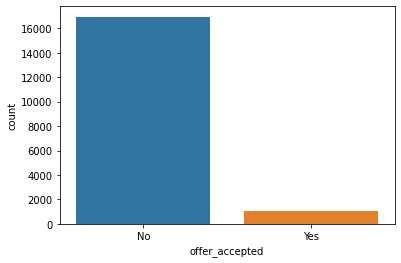

Column:  reward


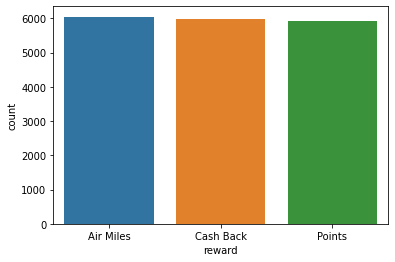

Column:  mailer_type


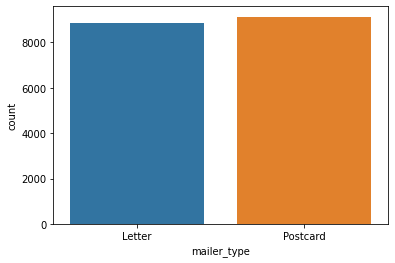

Column:  income_level


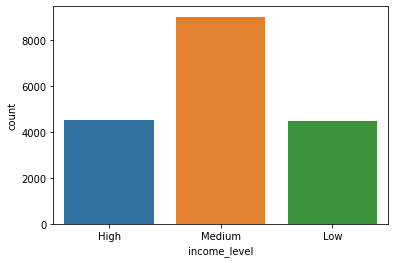

Column:  overdraft_protection


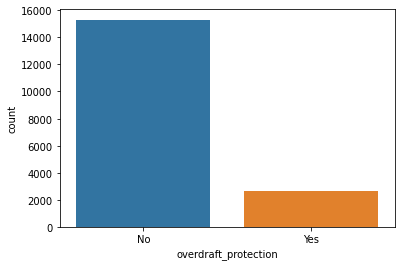

Column:  credit_rating


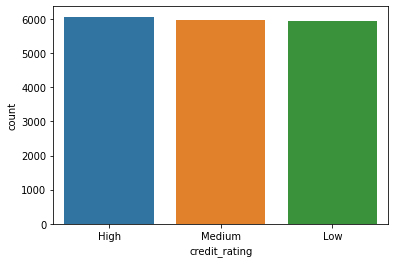

Column:  own_your_home


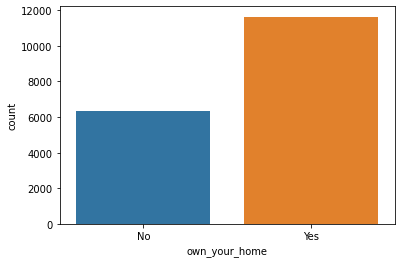

 
** PLOTING CONTINUOUS VARIABLES **
Column:  average_balance


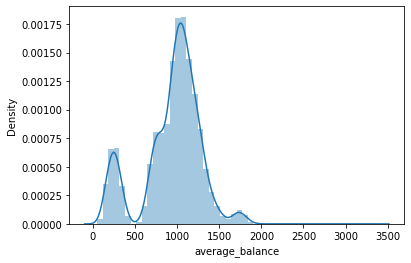

Column:  balance_q1


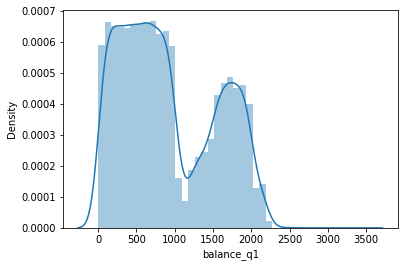

Column:  balance_q2


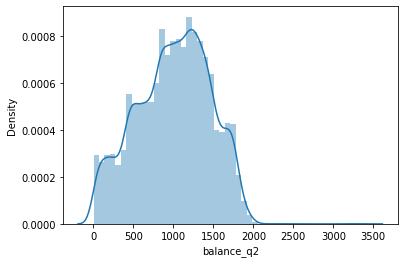

Column:  balance_q3


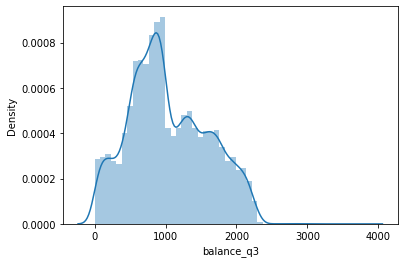

 
** PLOTTING DISCRETE VARIABLES **
Column:  nr_of_bank_accounts_open


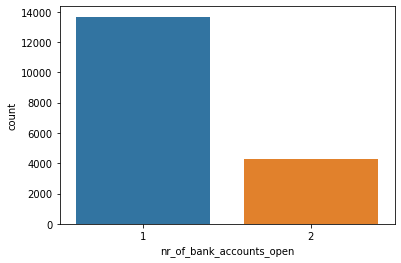

Column:  credit_cards_held


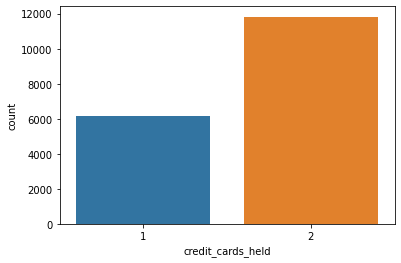

Column:  nr_of_homes_owned


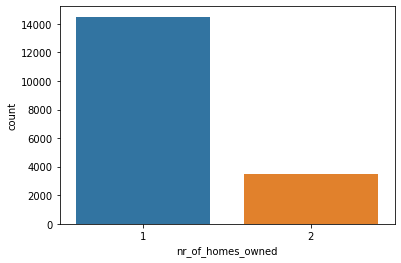

Column:  household_size


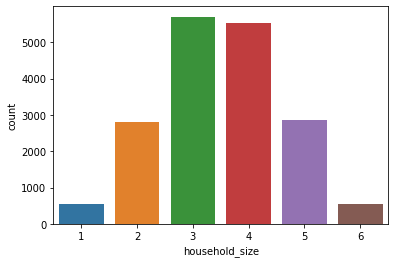

 
** PLOTTING CORRELATION MATRIX **


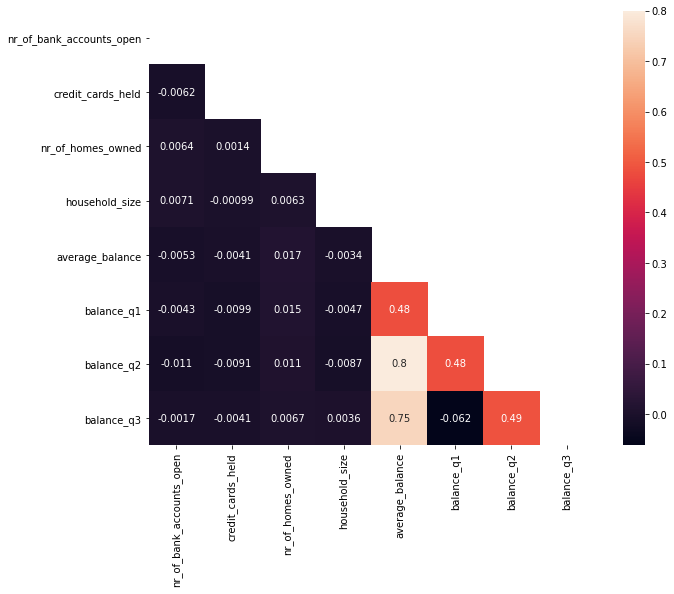

In [617]:
plot_master()

In [618]:
# Looking at dependency between categoricals with Chi-test 
applying_chi_test(cat)

RELATIONSHIP OFFER_ACCEPTED and REWARD
reward          Air Miles  Cash Back  Points
offer_accepted                              
No                   5583       5787    5578
Yes                   463        206     352
dof=2
[[5702.46580221 5652.4772664  5593.05693138]
 [ 343.53419779  340.5227336   336.94306862]]
probability=0.950, critical=5.991, stat=101.105
Dependent (reject H0)
significance=0.050, p=0.000
!!!!! DEPENDENT (reject H0)
RELATIONSHIP OFFER_ACCEPTED and MAILER_TYPE
mailer_type     Letter  Postcard
offer_accepted                  
No                8540      8408
Yes                300       721
dof=1
[[8337.71050142 8610.28949858]
 [ 502.28949858  518.71050142]]
probability=0.950, critical=3.841, stat=169.180
Dependent (reject H0)
significance=0.050, p=0.000
!!!!! DEPENDENT (reject H0)
RELATIONSHIP OFFER_ACCEPTED and INCOME_LEVEL
income_level    High   Low  Medium
offer_accepted                    
No              4352  4067    8529
Yes              165   387     469
do

In [619]:
# Skewness for numerical variables
skew_df(num_cont)

the skew of average_balance is: -0.5722743460162316
the skew of balance_q1 is: 0.4107547643914719
the skew of balance_q2 is: -0.18305623801164111
the skew of balance_q3 is: 0.28995754500514986


In [620]:
# VIF scores for numerical variables
vif_scores(num)

,independent_features,vif_score
0,nr_of_bank_accounts_open,7.772057
1,credit_cards_held,9.775468
2,nr_of_homes_owned,8.310816
3,household_size,8.657988
4,average_balance,79.665624
5,balance_q1,8.921909
6,balance_q2,17.575137
7,balance_q3,24.012667


# **3. Data encoding**

#### **3.2 Applying functions for data encoding**

In [621]:
# encoding categoricals
cat = converting_categoricals(cat)
cat.head()

,offer_accepted,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0
2,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1
3,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1
4,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0
5,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1


# **4. Prediction**

#### **4.2 Applying functions for prediction**

In [622]:
# getting X (features) and Y (target)
X,y = split_xy(cat,num)

In [624]:
# get metrics for every model, scaler and sampling to choose the best one
### CHOOSE metric BETWEEN 'logistic','decision_tree','k-nn'.
metric = 'logistic'
get_scores(X,y,metric)

,scaler,sampling,precision,recall,accuracy,kappa,set
0,normalizer,downsampling,-,-,0.53,0.05,train
1,normalizer,downsampling,0.0653565,0.448276,0.59,0.01,test
2,normalizer,upsampling,-,-,0.51,0.01,train
3,normalizer,upsampling,0.0655885,0.45768,0.58,0.01,test
4,normalizer,tomeklinks,-,-,0.94,0.00,train
5,normalizer,tomeklinks,0,0,0.94,0.00,test
6,standard,downsampling,-,-,0.69,0.39,train
7,standard,downsampling,0.118511,0.708464,0.67,0.11,test
8,standard,upsampling,-,-,0.69,0.38,train
9,standard,upsampling,0.120993,0.733542,0.67,0.12,test


The accuracy score in the TEST set is 0.67
 
The y test value counts are
 offer_accepted
0                 5072
1                  319
dtype: int64
 
Confusion matrix y_test,predictions
[[3380 1692]
 [  87  232]]
 
Confusion matrix X_test_t,y_test


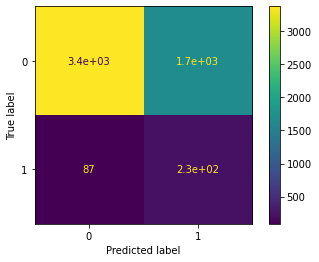

In [625]:
# choosing the best scaler, sampling and model to create the final confusion matrix and y-pred
# possible scalers: normalizer, standard, minmax, power
# possible samp (sampling): upsampling, downsampling, tomeklinks
# possible model: logistic, decision_tree, k-nn
scaler = 'standard'
samp  = 'upsampling'
model = 'logistic'

# confusion matrix information
confusion_matrix_info(X,y,scaler,samp,model)

In [626]:
# splitting data into train and teset
X_train, X_test, y_train, y_test = splitting_data(X,y)

In [627]:
# applying model, scaler, sampling decided before and check the predictions
X_train_t, X_test_t = scalers(X_train, X_test, scaler)
X_train_s, y_train_s = samplings_type(X_train_t, y_train, samp)
y_test = splitting_data(X,y)[3]
y_prediction = y_predict(X_train_s, X_test, y_train_s, y_test, model, k=None)
y_pred = pd.DataFrame(y_prediction).reset_index(drop=True)
y_test = pd.DataFrame(y_test).reset_index(drop=True)
y_pred_test = pd.concat([y_pred,y_test],axis=1,ignore_index=True)
y_pred_test.columns = ['offers_accepted_prediction','offers_accepted']
y_pred_test

,offers_accepted_prediction,offers_accepted
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0
...,...,...
5386,0,0
5387,0,0
5388,0,0
5389,0,0


Feature: 0, Score: 0.27352
Feature: 1, Score: -0.62296
Feature: 2, Score: -0.03767
Feature: 3, Score: -0.66864
Feature: 4, Score: 0.28153
Feature: 5, Score: -0.54473
Feature: 6, Score: 0.39424
Feature: 7, Score: -0.23662
Feature: 8, Score: -0.19911
Feature: 9, Score: -0.18800
Feature: 10, Score: -0.97145
Feature: 11, Score: 0.84338
Feature: 12, Score: -0.25904
Feature: 13, Score: -0.20582
Feature: 14, Score: -0.18129
Feature: 15, Score: -0.21233
Feature: 16, Score: -0.25111
Feature: 17, Score: -0.22706
Feature: 18, Score: -0.17165
Feature: 19, Score: -0.00046
Feature: 20, Score: -0.00011
Feature: 21, Score: 0.00008
Feature: 22, Score: 0.00013


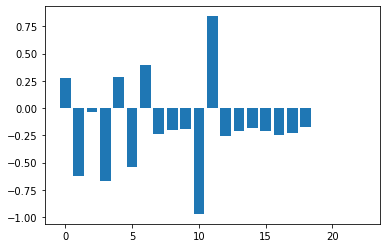

In [628]:
# checking the features importance of our data
model = 'logistic'
feature_importance(X,y,model)

**`Improving the model`**:

Dropping *overdraft_protection, own_your_home and reward_Points* improves the metrics (using logistic, standard,upsampling).
From the test set we can see that Kappa improves 1% with a 12%.
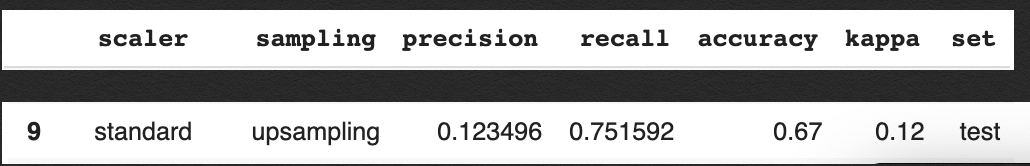

We have seen the model has improved so we continue dropping *the balance columns* and we see another kappa 1% improvement.

We are not able to continue improving the model.